In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api



In [2]:
data = pd.read_csv('singapore_airlines_reviews.csv')

In [3]:
data.head()

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0


In [4]:
data.shape

(10000, 7)

In [5]:
data.isna().sum()

published_date        0
published_platform    0
rating                0
type                  0
text                  0
title                 1
helpful_votes         0
dtype: int64

In [6]:
data[data.title.isna()]

,published_date,published_platform,rating,type,text,title,helpful_votes
3918,2019-09-01T04:18:02-04:00,Desktop,2,review,Very rude help desk of Singapore airlines at S...,NaN,1


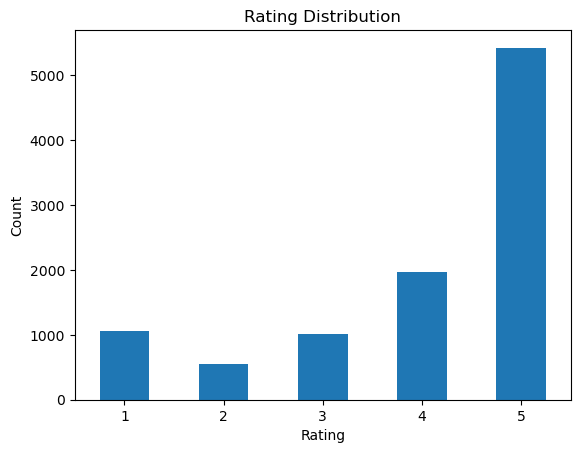

In [7]:
data.rating.value_counts().sort_index().plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation = 0)
plt.show()

In [8]:
data.rating = data.rating.apply(lambda x: 1 if x > 3 else 0)
data.rating

0       0
1       1
2       0
3       1
4       0
       ..
9995    1
9996    1
9997    1
9998    1
9999    1
Name: rating, Length: 10000, dtype: int64

In [9]:
data.rating.value_counts()

rating
1    7391
0    2609
Name: count, dtype: int64

In [10]:
from nltk.stem import WordNetLemmatizer
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaenho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(0, len(data)):
    review = re.sub('[^a-zA-Z]', ' ', data['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [lemmatizer.lemmatize(word) for word in review if word not in set(nltk.corpus.stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

In [14]:
corpus

['used airline go singapore london heathrow issue ticket cancelled one ticket trying get sorted cost lot money due roaming charge lengthy phone call needed get ticket reinstated trying charge varying amount resolve poor service got airport check desk due issue meant online check done premium economy spacious two seat either side plane seat middle plane seemed relatively new brand new legroom good seat wider bigger arm rest two seat fold away tray table good choice movie thing tv show game etc food ok seem much different economy standard flight crew seemed friendly enough really go isle drink maybe twice whole hour flight airline would done quite often overall flight ok seat comfy legroom good food ok flight crew could attentive especially premium economy would expect service slightly better economy',
 'service singapore airline suite class nothing excellent cabin crew warm friendly importantly came across sincere genuine throughout flight interacted leading stewardess sharifah went way

In [15]:
from nltk import sent_tokenize
from gensim.utils import simple_preprocess

In [16]:
words=[]
for sent in corpus:
    sent_token=sent_tokenize(sent)
    for sent in sent_token:
        words.append(simple_preprocess(sent))

In [20]:
words[0]

['used',
 'airline',
 'go',
 'singapore',
 'london',
 'heathrow',
 'issue',
 'ticket',
 'cancelled',
 'one',
 'ticket',
 'trying',
 'get',
 'sorted',
 'cost',
 'lot',
 'money',
 'due',
 'roaming',
 'charge',
 'lengthy',
 'phone',
 'call',
 'needed',
 'get',
 'ticket',
 'reinstated',
 'trying',
 'charge',
 'varying',
 'amount',
 'resolve',
 'poor',
 'service',
 'got',
 'airport',
 'check',
 'desk',
 'due',
 'issue',
 'meant',
 'online',
 'check',
 'done',
 'premium',
 'economy',
 'spacious',
 'two',
 'seat',
 'either',
 'side',
 'plane',
 'seat',
 'middle',
 'plane',
 'seemed',
 'relatively',
 'new',
 'brand',
 'new',
 'legroom',
 'good',
 'seat',
 'wider',
 'bigger',
 'arm',
 'rest',
 'two',
 'seat',
 'fold',
 'away',
 'tray',
 'table',
 'good',
 'choice',
 'movie',
 'thing',
 'tv',
 'show',
 'game',
 'etc',
 'food',
 'ok',
 'seem',
 'much',
 'different',
 'economy',
 'standard',
 'flight',
 'crew',
 'seemed',
 'friendly',
 'enough',
 'really',
 'go',
 'isle',
 'drink',
 'maybe',
 'twi

In [21]:
model = gensim.models.Word2Vec(words)

In [22]:
## To Get All the Vocabulary
model.wv.index_to_key

['flight',
 'singapore',
 'airline',
 'service',
 'seat',
 'food',
 'good',
 'time',
 'economy',
 'class',
 'staff',
 'crew',
 'meal',
 'one',
 'great',
 'would',
 'hour',
 'business',
 'comfortable',
 'cabin',
 'experience',
 'fly',
 'sq',
 'plane',
 'get',
 'always',
 'entertainment',
 'first',
 'excellent',
 'even',
 'leg',
 'back',
 'best',
 'passenger',
 'also',
 'long',
 'well',
 'could',
 'like',
 'check',
 'flying',
 'air',
 'premium',
 'much',
 'airport',
 'friendly',
 'trip',
 'drink',
 'better',
 'really',
 'way',
 'new',
 'travel',
 'customer',
 'choice',
 'year',
 'flew',
 'room',
 'day',
 'make',
 'return',
 'served',
 'never',
 'aircraft',
 'made',
 'still',
 'lounge',
 'attendant',
 'extra',
 'boarding',
 'got',
 'helpful',
 'take',
 'nice',
 'movie',
 'board',
 'need',
 'go',
 'flown',
 'ticket',
 'many',
 'however',
 'next',
 'booked',
 'two',
 'recommend',
 'told',
 'nothing',
 'little',
 'option',
 'attentive',
 'last',
 'use',
 'clean',
 'say',
 'book',
 'took',
 '

In [23]:
model.corpus_count

10000

In [26]:
model.wv.similar_by_word('food')

[('beverage', 0.7795953750610352),
 ('meal', 0.7566044330596924),
 ('wine', 0.7498773336410522),
 ('taste', 0.7272891402244568),
 ('pretty', 0.7263046503067017),
 ('tasty', 0.7205923795700073),
 ('quality', 0.7119479775428772),
 ('usual', 0.7092135548591614),
 ('plentiful', 0.7083938717842102),
 ('average', 0.7067924737930298)]

In [27]:
# Give progress bar while the code is running
from tqdm import tqdm

def avg_word2vec(doc):
    return np.mean([model.wv[word] for word in doc if word in model.wv.index_to_key],axis=0)

X=[]
for i in tqdm(range(len(words))):
    X.append(avg_word2vec(words[i]))

100%|██████████| 10000/10000 [00:02<00:00, 3497.91it/s]


In [28]:
X

[array([-3.89963865e-01,  9.22410339e-02, -5.39035350e-02, -1.73429817e-01,
         5.52239679e-02, -4.22671795e-01,  3.00255656e-01,  1.89859360e-01,
        -3.58497798e-01, -5.78439422e-02,  5.64341014e-03, -4.01021212e-01,
        -2.69116938e-01,  1.67451128e-01, -3.24562774e-04, -1.26725763e-01,
        -2.98521202e-02, -2.71704882e-01,  3.60732079e-02, -5.90555489e-01,
         2.50008255e-01,  3.42628337e-03,  4.18176383e-01, -2.32382238e-01,
         8.36533215e-03,  9.90719814e-03, -1.10296331e-01, -3.33605409e-01,
        -3.27092081e-01, -5.99949896e-01,  3.26873928e-01,  4.21719179e-02,
         2.86936611e-01,  5.60770892e-02,  1.26239613e-01,  1.80020645e-01,
        -6.56901896e-02, -1.47921622e-01,  8.89565945e-02, -4.12908077e-01,
        -6.68777078e-02, -3.85964304e-01, -1.22569956e-01,  5.12369163e-02,
         4.18300569e-01, -1.55815199e-01, -3.56550843e-01,  2.77988464e-01,
         5.26075996e-02,  1.50502533e-01,  9.05608758e-02, -3.51000309e-01,
         1.1

In [29]:
len(X)

10000

In [48]:
Y = data.rating

In [51]:
# This is the final independent features, reshaped to transform the average word2vec from column vector to row vector for every review
df = pd.DataFrame()
for i in range(len(X)):
    df = pd.concat([df, pd.DataFrame(X[i].reshape(1, -1))])


# Adding the rating column to the df
df['rating'] = Y.values

In [54]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,rating
0,-0.389964,0.092241,-0.053904,-0.173430,0.055224,-0.422672,0.300256,0.189859,-0.358498,-0.057844,...,0.006908,0.098377,0.134043,0.682141,0.414766,-0.037509,-0.159631,0.247576,-0.120644,0
0,-0.415573,0.067631,-0.271944,-0.160250,-0.031501,-0.573815,0.175781,0.261644,-0.553382,-0.026143,...,0.069189,0.044242,0.158301,0.534019,0.063469,0.031529,-0.109131,0.402918,-0.070853,1
0,-0.612739,0.232044,0.066121,0.135617,0.221046,-0.528501,0.188670,0.122674,-0.363428,0.157225,...,0.050159,0.307481,-0.059730,0.607145,0.371498,-0.120627,-0.118916,0.511551,-0.138457,0
0,0.284296,0.499276,-0.270492,-0.160573,0.420992,-0.287150,0.418499,0.764648,0.191260,-0.566520,...,0.134468,0.237863,0.027230,0.711192,0.057798,-0.032038,-0.101407,-0.025690,-0.393213,1
0,-0.300233,0.222522,-0.120897,-0.201586,0.103876,-0.398529,0.187776,0.091652,-0.164782,-0.001756,...,0.160691,0.160871,0.021753,0.659898,0.341437,-0.003250,-0.179959,0.290367,-0.214999,0


In [55]:
df.shape

(10000, 101)

In [56]:
y = df['rating']

In [57]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20)

------------------------------------
LogisticRegression
Accuracy: 0.87
Recall: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       501
           1       0.90      0.93      0.92      1499

    accuracy                           0.87      2000
   macro avg       0.84      0.82      0.82      2000
weighted avg       0.87      0.87      0.87      2000



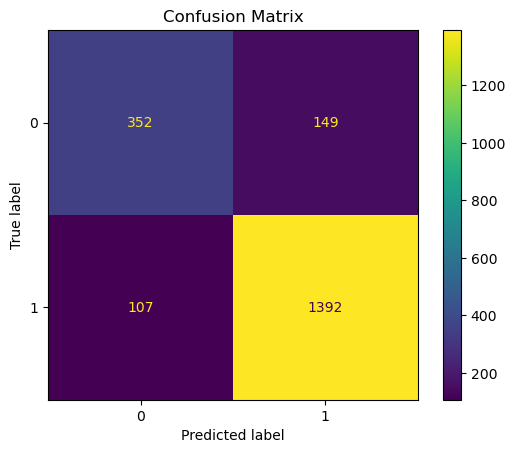

------------------------------------
------------------------------------
NaiveBayes
Accuracy: 0.78
Recall: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.85      0.66       501
           1       0.94      0.76      0.84      1499

    accuracy                           0.78      2000
   macro avg       0.74      0.80      0.75      2000
weighted avg       0.84      0.78      0.79      2000



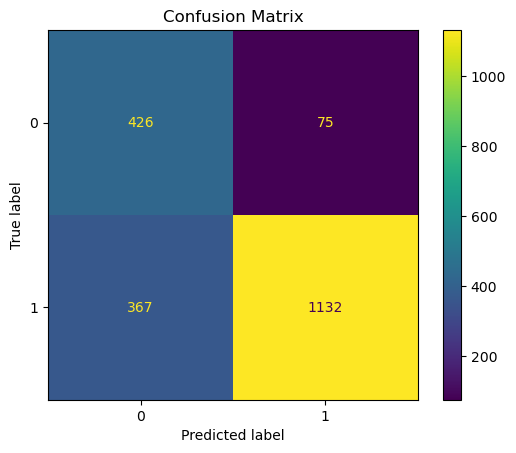

------------------------------------
------------------------------------
DecisionTree
Accuracy: 0.79
Recall: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.59      0.59       501
           1       0.86      0.85      0.86      1499

    accuracy                           0.79      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.79      0.79      0.79      2000



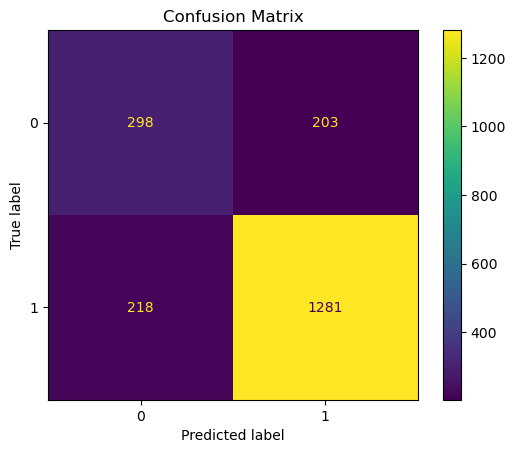

------------------------------------
------------------------------------
SupportVectorMachine
Accuracy: 0.87
Recall: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.68      0.73       501
           1       0.90      0.94      0.92      1499

    accuracy                           0.87      2000
   macro avg       0.84      0.81      0.82      2000
weighted avg       0.87      0.87      0.87      2000



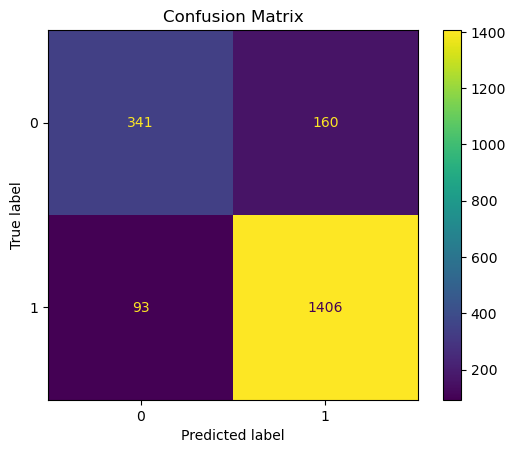

------------------------------------
------------------------------------
RandomForest
Accuracy: 0.87
Recall: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.67      0.72       501
           1       0.89      0.93      0.91      1499

    accuracy                           0.87      2000
   macro avg       0.83      0.80      0.81      2000
weighted avg       0.86      0.87      0.86      2000



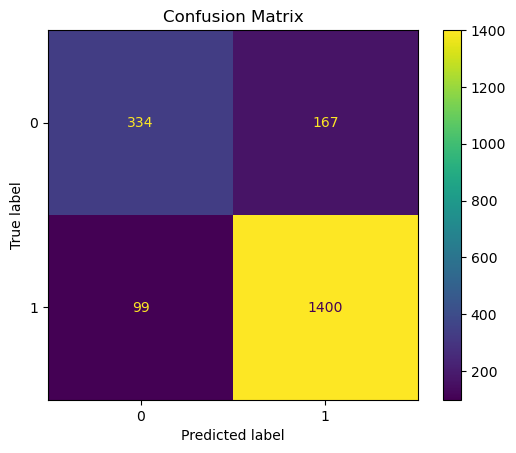

------------------------------------


/Users/michaenho/anaconda3/envs/PythonML/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


------------------------------------
AdaBoost
Accuracy: 0.85
Recall: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.67      0.70       501
           1       0.89      0.91      0.90      1499

    accuracy                           0.85      2000
   macro avg       0.81      0.79      0.80      2000
weighted avg       0.85      0.85      0.85      2000



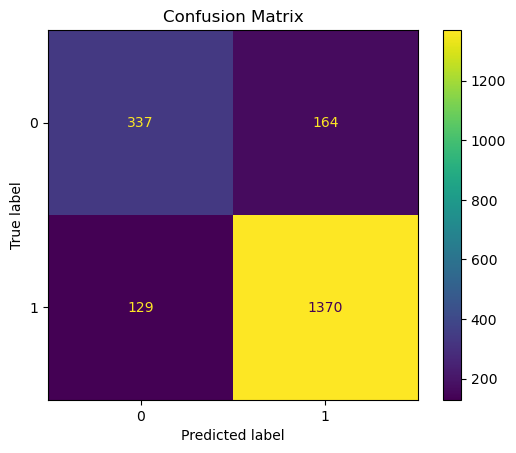

------------------------------------
------------------------------------
GradientBoosting
Accuracy: 0.87
Recall: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       501
           1       0.90      0.93      0.91      1499

    accuracy                           0.87      2000
   macro avg       0.83      0.81      0.82      2000
weighted avg       0.86      0.87      0.87      2000



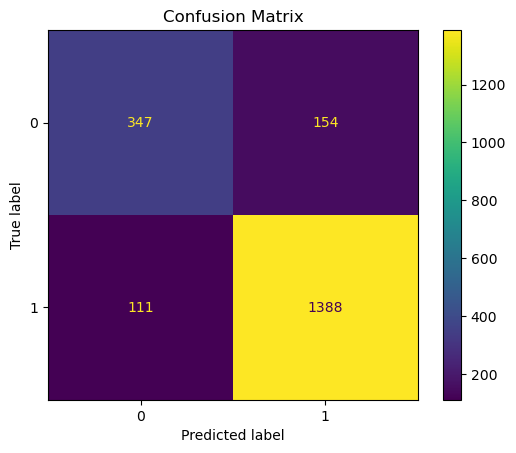

------------------------------------
------------------------------------
XGBoost
Accuracy: 0.87
Recall: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       501
           1       0.90      0.93      0.91      1499

    accuracy                           0.87      2000
   macro avg       0.83      0.81      0.82      2000
weighted avg       0.86      0.87      0.87      2000



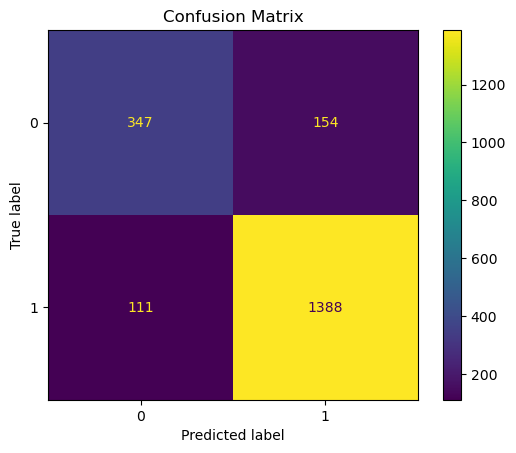

------------------------------------


In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

models = {
    'LogisticRegression': LogisticRegression(),
    'NaiveBayes': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(),
    'SupportVectorMachine': SVC(),
    'RandomForest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()


}
def model_fit(models):
    for model_name in models:
        model = models[model_name]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print('------------------------------------')
        print(model_name)
        print(f'Accuracy: {accuracy_score(y_test,y_pred):.2f}')
        print(f'Recall: {recall_score(y_test,y_pred):.2f}')
        print('Classification Report:')
        print(classification_report(y_test,y_pred))
        ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()
        plt.title("Confusion Matrix")
        plt.show()
        print('------------------------------------')
    
model_fit(models)
